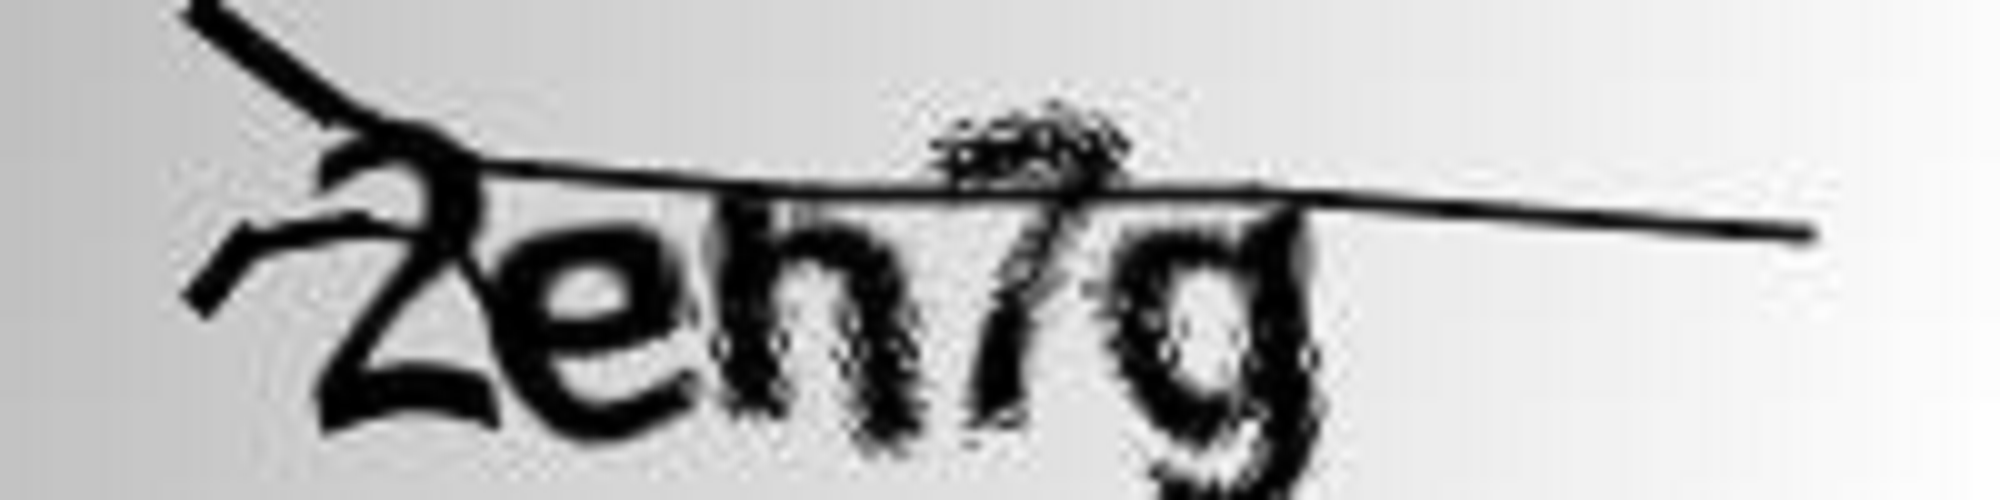

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>Abstract</p>
</div>

In this notebook, I used the [CAPTCHA dataset](https://www.kaggle.com/fournierp/captcha-version-2-images) provided by @fournierp and I tested 2 solutions to read CAPTCHA images. 

**The 1st solution solution combines a CNN and a FC Classifier and achieves pretty good performance (>94%)**. It :
- crops the image around the characters and flips the cropped image (as we want the time dimension to correspond to the width of the image).  
- uses a CNN to extract features from the cropped image.
- reshapes the features to "split" them into 5 time-steps. 
- uses a FC Classifier to predict 5 characters : for each time-step, the output is the probability distribution of a character being at this step.  

**The 2nd solution implements a CNN LSTM architecture with CTC operation and achieves great performance (>99%). All the credits for this solution go to [A_K_Nain](https://keras.io/examples/vision/captcha_ocr/)**. It:
- flips the input image (as we want the "time dimension" to correspond to the width of the image).
- uses a CNN to extract features from the image.
- uses a CNN encoder (which consists of a single Fully Connected layer) to encode the features into 50 time-steps
- uses 2 BRNNs to process a sequence of 50 steps : for each time-step, the output is the probability distribution of a character being at this step.
- uses a CTC decoder to predict 5 characters.  

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>Quick EDA</p>
</div>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

img_folder = 'input/captcha-version-2-images/samples/'

A quick overview of the dataset provided by @fournierp https://www.kaggle.com/fournierp/captcha-version-2-images :
- The dataset contains 1070 files. 
- Each file is an image representing a CAPTCHA image. 
- The image is either in png format (1040 png files) or in jpg format (30 jpg files). 
- The file name is composed of the 5 characters contained in the CAPTCHA image followed by the image format (e.g. 2g7nm.png) 

In [ ]:
img_2g7nm = mpimg.imread(img_folder + '2g7nm.png')
img_34pcn = mpimg.imread(img_folder + '34pcn.png')
img_bny23 = mpimg.imread(img_folder + 'bny23.png')
img_c4mcm = mpimg.imread(img_folder + 'c4mcm.png')
img_3c7de = mpimg.imread(img_folder + '3c7de.jpg')
img_nxf2c = mpimg.imread(img_folder + 'nxf2c.jpg')
img_pcmcc = mpimg.imread(img_folder + 'pcmcc.jpg')
img_yge7c = mpimg.imread(img_folder + 'yge7c.jpg')
samples = {'2g7nm.png':img_2g7nm, '34pcn.png':img_34pcn, 'bny23.png':img_bny23, 'c4mcm.png':img_c4mcm, 
           '3c7de.jpg':img_3c7de, 'nxf2c.jpg':img_nxf2c, 'pcmcc.jpg':img_pcmcc, 'yge7c.jpg':img_yge7c}

fig=plt.figure(figsize=(20, 5))
pos = 1
for filename, img in samples.items():
    fig.add_subplot(2, 4, pos)
    pos = pos+1
    plt.imshow(img)
    plt.title('filename='+filename+' shape='+str(img.shape))
plt.show()

Each image has 50x200 pixels. That said, the shape of the array differs between jpg and png images indicating that jpg images are RGB and png are RGBA. Since images are black & white, R, G and B are all similar. Also for png images, there is no differecence in transparency (alpha is always 1). 

Now, looking at the characters in the CAPTCHA images, one can notice that:
- only 19 characters are used 2,3,4,5,6,7,8 and b,c,d,e,f,g,m,n,p,w,x,y
- the frequency of each character is roughly the same with one exception : n is used twice often than other characters

In [ ]:
df = pd.DataFrame(columns=['filename','extension','label','labelsize','char1','char2','char3','char4','char5'])
i = 0
for _, _, files in os.walk(img_folder):
    for f in files:
        df.loc[i,'filename'] = f
        df.loc[i,'extension'] = f.split('.')[1]
        df.loc[i,'label'] = f.split('.')[0]
        df.loc[i,'labelsize'] = len(f.split('.')[0])
        df.loc[i,'char1'] = f.split('.')[0][0]
        df.loc[i,'char2'] = f.split('.')[0][1]
        df.loc[i,'char3'] = f.split('.')[0][2]
        df.loc[i,'char4'] = f.split('.')[0][3]
        df.loc[i,'char5'] = f.split('.')[0][4]
        i = i+1
        
#df.head()

data = pd.DataFrame(df['char1'].value_counts()+df['char2'].value_counts()+df['char3'].value_counts()+df['char4'].value_counts()+df['char5'].value_counts()).reset_index()
data.columns = ['character','count']

sns.barplot(data=data, x='character', y='count')
plt.show()

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>Definition of the evaluation metric</p>
</div>

We will assess the performance of the different models on the validation dataset that contains 10% of the complete dataset. 

For each image in the validation set, we will compare the true label with the prediction. The true label and the prediction are (5,1) vectors. Therefore we will compare the vectors element-wise and count the number of good predictions element-wise. For each image, the score will be (nb of good predictions element-wise)/5. 

E.g. :   
- the true label corresponding to the image 368y5.png is [1 4 6 18 3] (after transforming the characters to numerical values)
- if the predicted label is [1 4 6 18 3], then the score for this image is 1
- if the predicted label is [2 6 4 10 1], then the score for this image is 0
- if the predicted label is [1 6 6 10 1], then the score for this image is 0.4 (2 characters correctly predicted)

**The performance of the model will be the average of the scores for each image in the validation set. This number corresponds to the percentage of characters that are correctly predicted.**

In [ ]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
        return np.sum(predictions == groundtruth)/(predictions.shape[0]*predictions.shape[1])
    else:
        raise Exception('Error : the size of the arrays do not match. Cannot compute the performance metric')

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>Creation of the training and validation datasets</p>
</div>

This section generates the training set that will be used to train the neural network and the validation set that will be used to evaluate the model performance.

The training set will have 90% of the data :
- X_train with 936 images. X_train shape will be (936,50,200,1) 
- y_train with 936 labels. y_train shape will be (936,5)  

The validation set will have 10% of the data 
- X_val with 104 images. X_val shape will be (104,50,200,1) 
- y_val with 104 labels. y_val shape will be (104,5)

The label corresponding to each image is a string corresponding to the filename minus the extension. As the neural net deals only with numerical values, we will have to map each character in the string to an integer.

In [ ]:

# Dictionaries that will be used to convert characters to integers and vice-versa
vocabulary = {'0','1','2','3','4','5','6','7','8','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'}
char_to_num = {c:i for i,c in enumerate(vocabulary)}

print(char_to_num)

##############################################################################################################################
# This function encodes a single sample. 
# Inputs :
# - img_path : the string representing the image path e.g. '/kaggle/input/captcha-version-2-images/samples/samples/6n6gg.jpg'
# - label : the string representing the label e.g. '6n6gg'
# - crop : boolean, if True the image is cropped around the characters and resized to the original size.
# Outputs :
# - a multi-dimensional array reprensenting the image. Its shape is (50, 200, 1)
# - an array of integers representing the label after encoding the characters to integer. E.g [6,16,6,14,14] for '6n6gg' 
##############################################################################################################################
def encode_single_sample(img_path, label, crop):
    # Read image file and returns a tensor with dtype=string
    img = tf.io.read_file(img_path)
    # Decode and convert to grayscale (this conversion does not cause any information lost and reduces the size of the tensor)
    # This decode function returns a tensor with dtype=uint8
    img = tf.io.decode_png(img, channels=1) 
    # Scales and returns a tensor with dtype=float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Crop and resize to the original size : 
    # top-left corner = offset_height, offset_width in image = 0, 25 
    # lower-right corner is at offset_height + target_height, offset_width + target_width = 50, 150
    if(crop==True):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=10, target_height=50, target_width=180)
        img = tf.image.resize(img,size=[50,200],method='bilinear', preserve_aspect_ratio=False,antialias=False, name=None)
    # Transpose the image because we want the time dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # Converts the string label into an array with 5 integers. E.g. '6n6gg' is converted into [6,16,6,14,14]
    label = list(map(lambda x:char_to_num[x], label))
    return img.numpy(), label

def create_train_and_validation_datasets( crop=False):
    """
    Creates training and validation datasets from image files in a folder.

    Args:
        img_folder (str): Path to the folder containing image files.
        encode_single_sample (function): Function to encode a single image and its label.
        crop (bool, optional): Whether to crop images. Defaults to False.

    Returns:
        tuple: (X_train, X_val, y_train, y_val) containing the training and validation datasets.
    """
    X, y = [], []

    for _, _, files in os.walk(img_folder):
        for f in files:
            label = f.split('.')[0]
            extension = f.split('.')[1]
            if extension == 'png':
                img, label = encode_single_sample(os.path.join(img_folder, f), label, crop)
                X.append(img)
                y.append(label)

    # print("Number of labels:", len(y),y)
    X = np.array(X)
    # print("X shape:", X.shape)
    for arr in y:
        # print(arr)
        if len(arr) != 5:
            print(arr) 
    
    # print(y)
    y = np.array(y)

    

    num_samples = X.shape[0]  # Get the number of samples

    if num_samples == 0:
        raise ValueError("No PNG images found in the specified folder.")

    # Calculate the test size based on 10% of the total samples
    test_size = 0.1
    X_train, X_val, y_train, y_val = train_test_split(X.reshape(num_samples, -1), y, test_size=test_size, shuffle=True, random_state=42)

    # Calculate the new reshape dimensions
    original_height = X.shape[1]
    original_width = X.shape[2]
    original_channels = X.shape[3]

    train_samples = X_train.shape[0]
    val_samples = X_val.shape[0]

    X_train = X_train.reshape(train_samples, original_height, original_width, original_channels)
    X_val = X_val.reshape(val_samples, original_height, original_width, original_channels)

    return X_train, X_val, y_train, y_val

Let's check a few examples :   
- images on the 1st row are transposed, cropped around the characters and resized as expected by the "classifier-like" model
- images on the 2nd row are transposed only as expected by the CNN LSTM model

In [ ]:
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)
X_train_, X_val_, y_train_, y_val_ = create_train_and_validation_datasets(crop=False)

fig=plt.figure(figsize=(20, 10))
fig.add_subplot(2, 4, 1)
plt.imshow(X_train[0], cmap='gray')
#plt.imshow(X_train[0].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_train with label '+ str(y_train[0]))
plt.axis('off')
fig.add_subplot(2, 4, 2)
plt.imshow(X_train[935], cmap='gray')
#plt.imshow(X_train[935].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_train with label '+ str(y_train[935]))
plt.axis('off')
fig.add_subplot(2, 4, 3)
plt.imshow(X_val[0], cmap='gray')
#plt.imshow(X_val[0].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_val with label '+ str(y_val[0]))
plt.axis('off')
fig.add_subplot(2, 4, 4)
plt.imshow(X_val[103], cmap='gray')
#plt.imshow(X_val[103].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_val with label '+ str(y_val[103]))
plt.axis('off')
fig.add_subplot(2, 4, 5)
plt.imshow(X_train_[0], cmap='gray')
plt.title('Image from X_train with label '+ str(y_train_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 6)
plt.imshow(X_train_[935], cmap='gray')
plt.title('Image from X_train with label '+ str(y_train_[935]))
plt.axis('off')
fig.add_subplot(2, 4, 7)
plt.imshow(X_val_[0], cmap='gray')
plt.title('Image from X_val with label '+ str(y_val_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 8)
plt.imshow(X_val_[103], cmap='gray')
plt.title('Image from X_val with label '+ str(y_val_[103]))
plt.axis('off')
plt.show()

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>The classifier-like model</p>
</div>

**This solution solution combines a CNN and a FC Classifier and achieves pretty good performance (>94%)**. It :
- crops the image around the characters and flips the cropped image (as we want the time dimension to correspond to the width of the image).  
- uses a CNN to extract features from the cropped image.
- reshapes the features to "split" them into 5 time-steps. 
- uses a FC Classifier to predict 5 characters : for each time-step, the output is the probability distribution of a character being at this step.  

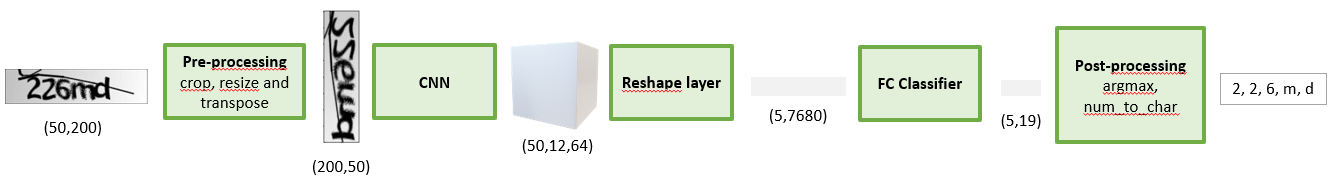

## Build Model

In [ ]:
def build_model():
    
    # Inputs to the model
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64 --> output volume shape = (50,12,64) 
    # Reshape to 5 time steps
    x = layers.Reshape(target_shape=(5, -1), name="reshape")(x)

    # Fully Connected Layers
    x = layers.Dense(128, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.3)(x)  # More dropout to prevent overfitting
    x = layers.Dense(64, activation="relu", name="dense2")(x)
   
    # Output layer
    output = layers.Dense(36, activation="softmax", name="dense3")(x) 
    
    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=output, name="ocr_classifier_based_model")
    
    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


# Get the model
model = build_model()
model.summary()

## Train the model

In [ ]:
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)
# print(X_train, X_val, y_train, y_val)
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=30)

In [ ]:
fig=plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Predictions

Let's use this model to predict the labels for the 104 images of the validation set :

In [ ]:
y_pred = model.predict(X_val) # y_pred shape = (104,50,19)
y_pred = np.argmax(y_pred, axis=2)

# creat num_to_char reverse of char_to_num
num_to_char = {str(v):k for k,v in char_to_num.items()}
num_to_char['-1'] = 'UKN'
print(num_to_char)
# num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_val[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show() 

## Model Performance

Let's use the function compute_perf_metric to calculate the performance metric of this model. Reminder : this metric corresponds to the percentage of characters that are correctly predicted (and this % is calculated using the 104 images hence 520 characters of the validation set).

In [ ]:
compute_perf_metric(y_pred, y_val)

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>The CNN LSTM model</p>
</div>

**This solution implements a CNN LSTM architecture with CTC loss and achieves great performance (>99%). All the credits for this solution go to [A_K_Nain](https://keras.io/examples/vision/captcha_ocr/)**. It:
- flips the input image (as we want the "time dimension" to correspond to the width of the image).
- uses a CNN to extract features from the image.
- uses a CNN encoder (which consists of a single Fully Connected layer) to encode the features into 50 time-steps
- uses 2 BRNNs to process a sequence of 50 steps : for each step, the output is the probability distribution of a character being at this step.
- uses a CTC decoder to predict 5 characters.

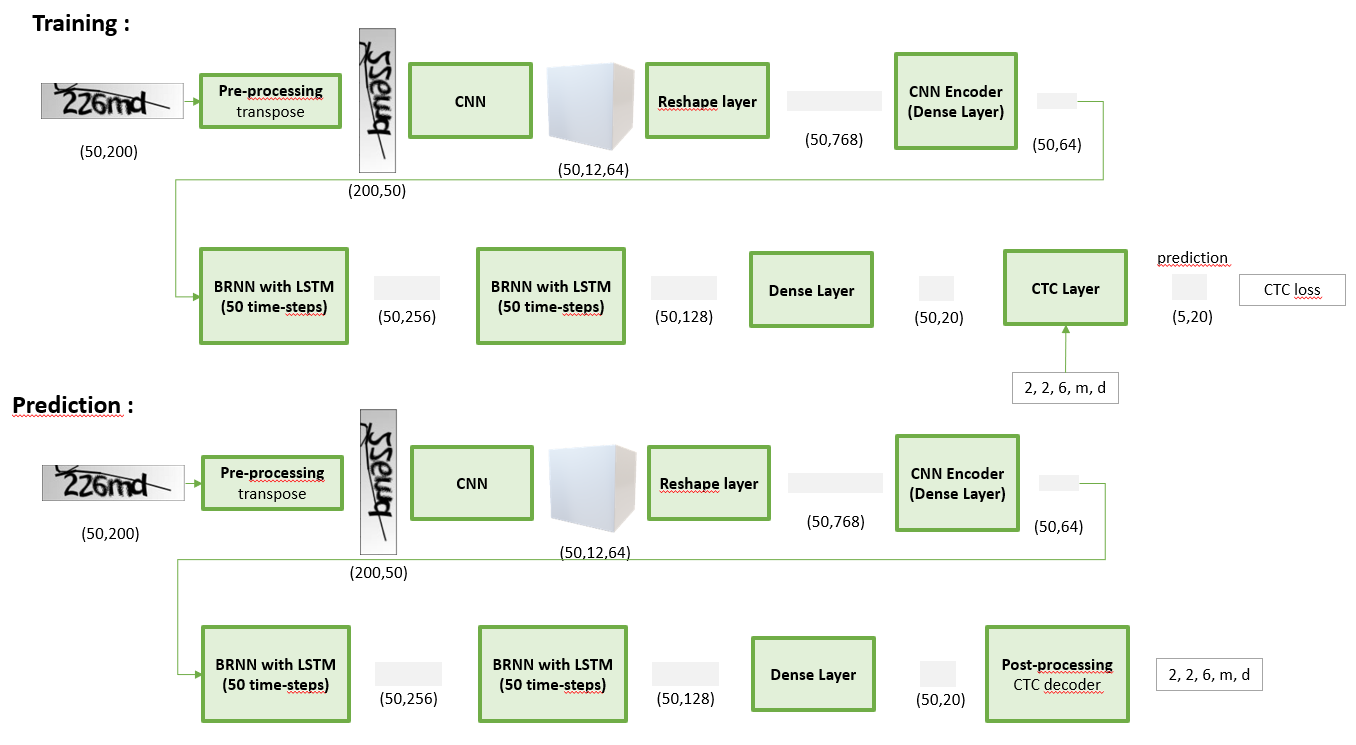


## Build Model

In [ ]:
# Let's create a new CTCLayer by subclassing
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model():
    
    # Inputs to the model
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model 
    x = layers.Reshape(target_shape=(50, 768), name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(37, activation="softmax", name="dense2")(x) # 20 = 19 characters + UKN

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_cnn_lstm_model")
    
    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam())
    return model


# Get the model
model = build_model()
model.summary()

## Train the model

In [ ]:
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=False)

# Add early stopping
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = model.fit([X_train, y_train], y_train, validation_data=([X_val, y_val], y_val), epochs=100)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('CTC loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## Predictions

Now we have a trained model that performs well on both the training and validation sets from a CTC loss perspective. Let's shrink it to take only the layers that will be used to make predictions :

In [ ]:
print("Model Inputs:", model.inputs)

image_input_tensor = model.inputs[0] #access the input tensor from the model.inputs list.
print("Image Input Tensor:", image_input_tensor)

prediction_model = keras.models.Model(
    image_input_tensor, model.get_layer(name="dense2").output
)
prediction_model.summary()

Let's use this model to predict the labels for the 104 images of the validation set :

In [ ]:
y_pred = prediction_model.predict(X_val)  # y_pred shape = (104, 50, 20)
y_pred = keras.backend.ctc_decode(y_pred, input_length=np.ones(len(X_val)) * 50, greedy=True)  # decoding -> y_pred[0].shape = (104, 5)
# y_pred[0][0][X][0:5] corresponds to the prediction of one image (with X in [0,...,103])
# it is a tensor whose corresponding numpy array is for example [15,  7, 15, 12,  8]
y_pred = y_pred[0][0][0:2, :].numpy()  # y_pred.shape=(2, 5)

print(y_pred)

Let's display 10 images and their predicted labels. This model is really making great:

In [ ]:
num_to_char = {str(v):k for k,v in char_to_num.items()}
num_to_char['-1'] = 'UKN'
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_val[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show()    


## Model performance

Let's use the function compute_perf_metric to calculate the performance metric of this model. Reminder : this metric corresponds to the percentage of characters that are correctly predicted (and this % is calculated using the 104 images hence 520 characters of the validation set).

In [ ]:
compute_perf_metric(y_pred, y_val)

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>References</p>
</div>

https://machinelearningmastery.com/cnn-long-short-term-memory-networks/  
https://keras.io/examples/vision/captcha_ocr/   
https://www.tensorflow.org/guide/keras/rnn  
https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c